In [1]:
from pathlib import Path
import json

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd

from scipy.stats import lognorm

import astropy
from astropy import stats
from astropy.time import Time, TimezoneInfo
import astropy.units as u
from astropy.visualization import time_support, hist
from astropy.table import Table
from astropy.coordinates import SkyCoord, EarthLocation, TETE
from astropy.table import Table
from astropy.io import ascii

from photutils.aperture import ApertureStats
import photutils

from timdimm_tng.ser import load_ser_file
from timdimm_tng.analyze_cube import find_apertures, analyze_dimm_cube, seeing

time_support(simplify=True)

<astropy.visualization.time.time_support.<locals>.MplTimeConverter at 0x7f8bb9b525a0>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [39]:
testfile = Path.home() / "MMT/fassdimm_data/indi_record_2023-12-13@05-14-13.ser"
testfile = Path.home() / "MMT/fassdimm_data/indi_record_2023-12-13@05-08-47.ser"
testfile = Path.home() / "MMT/fassdimm_data/indi_record_2023-12-13@04-33-55.ser"
testfile = Path.home() / "MMT/fassdimm_data/indi_record_2023-12-13@04-23-53.ser"
testfile = Path.home() / "MMT/fassdimm_data/indi_record_2023-12-13@02-54-30.ser"
testfile = Path.home() / "MMT/fassdimm_data/indi_record_2023-12-13@02-53-10.ser"
testfile = Path.home() / "MMT/fassdimm_data/indi_record_2023-12-13@02-38-45.ser"
testfile = Path.home() / "MMT/fassdimm_data/indi_procyon_2023-12-13@08-01-56.ser"
testfile = Path.home() / "MMT/fassdimm_data/indi_capella_2023-12-13@10-19-07.ser"
#testfile = Path.home() / "MMT/fassdimm_data/indi_record_2024-05-24@07-57-52.ser"
#testfile = Path.home() / "MMT/fassdimm_data/indi_record_2024-05-24@07-11-02.ser"
#testfile = Path.home() / "MMT/fassdimm_data/indi_record_2024-05-24@08-32-39.ser"

d = load_ser_file(testfile)

(<Quantity 1.86204141 arcsec>,
 [<Quantity 1.79838008 arcsec>,
  <Quantity 1.64871352 arcsec>,
  <Quantity 2.13903061 arcsec>],
 0)

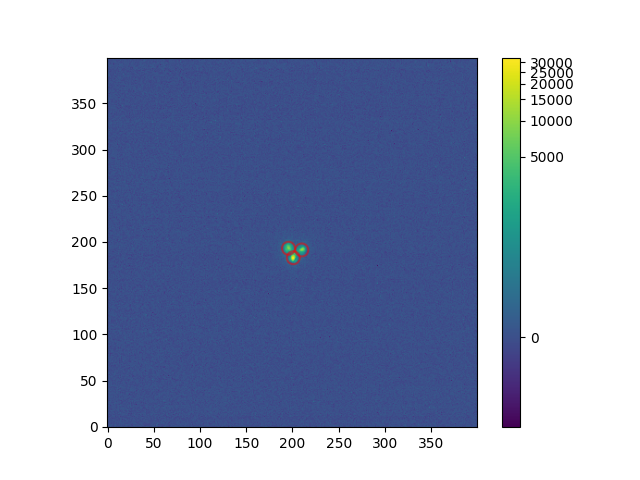

In [41]:
airmass = 1/np.cos(90 * u.deg - 62 * u.deg)
airmass = 1.0
results = analyze_dimm_cube(testfile, airmass=airmass, seeing_func=seeing, napertures=3, ap_size=7, plot=True)
results["seeing"], results['raw_seeing'], results['N_bad']

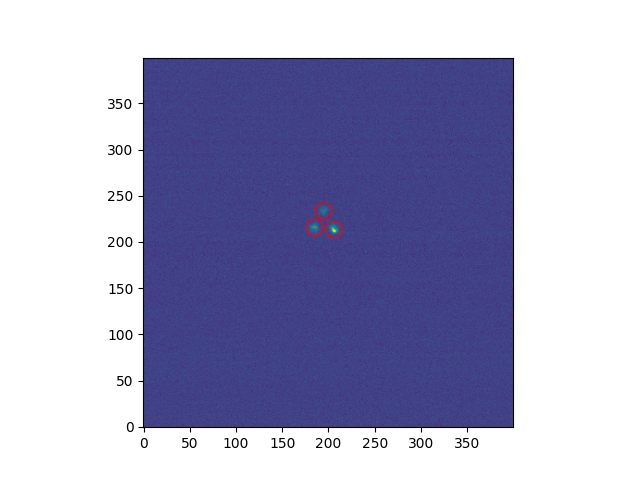

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int32,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3,195.01295796541203,233.34569269681444,None,192,198,230,236,29.0,1.7150624726183774,1.3536589607124396,37.87166237184188,0.614037611000914,61.14132849922265,125.14132849922265,0.0,2701.098526477457,nan,6834.425726367967,nan
2,185.002368019362,215.23745535884458,None,181,189,212,218,46.0,1.9530172879852414,1.5749837441314605,-10.52531513672819,0.5913211772916739,45.14132849922265,221.14132849922265,0.0,5852.50111096424,nan,10636.343893113743,nan
1,205.95110646975448,212.83356618793923,None,202,210,209,218,65.0,2.242172801899178,1.724559766563959,-52.806172467409766,0.6390722843678159,61.14132849922265,477.14132849922265,0.0,12774.186352449473,nan,16336.35172322206,nan


In [34]:
fig, ax = plt.subplots()
idx = 1443
im = d["data"][idx]
ap_size = 9
mean, median, std = stats.sigma_clipped_stats(im, sigma=3.0, maxiters=5)

data = im - mean
threshold = 5 * std
kernel = photutils.segmentation.make_2dgaussian_kernel(3, size=3)
convolved_data = astropy.convolution.convolve(data, kernel)
finder = photutils.segmentation.SourceFinder(npixels=15, progress_bar=False)
segment_map = finder(convolved_data, threshold)
t = photutils.segmentation.SourceCatalog(data, segment_map, convolved_data=convolved_data).to_table()
t.sort('max_value')
spots = t[-3:]

positions = list(zip(spots['xcentroid'], spots['ycentroid']))
apertures = photutils.aperture.CircularAperture(positions, r=ap_size)

ax.imshow(im, origin="lower")
apertures.plot(color='red', lw=1.5, alpha=0.5, axes=ax)
plt.show()
spots

/home/tim/conda/envs/timdimm/lib/python3.12/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


array([51336.89192954, 73997.55548105, 97400.83284761])

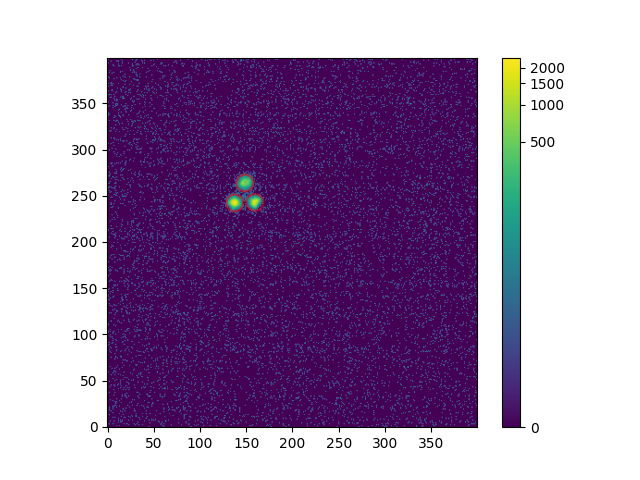

In [204]:
ap_im = np.mean(d["data"][:1], axis=0)
aps = find_apertures(ap_im, fwhm=11, ap_size=9, plot=True)
ap_stats = ApertureStats(ap_im, aps[0])
np.mean(ap_stats.centroid, axis=0), (ap_stats.max.max() > 16000),
ap_stats.sum

In [14]:
ave_im = np.mean(d['data'][:10], axis=0)
aps = find_apertures(ave_im, brightest=2)
ap_stats = ApertureStats(ave_im, aps[0])
ap_stats.centroid, ap_stats.max, np.mean(ap_stats.centroid, axis=0)

(array([[226.84209193, 192.4279562 ],
        [182.68432396, 207.55939958]]),
 array([2801.6, 1540.8]),
 array([204.76320794, 199.99367789]))

In [33]:
ap_stats.max.max()

668.8

In [34]:
x, y = np.mean(ap_stats.centroid, axis=0)
x, y

(175.57218138617034, 211.53527219935097)

In [58]:
results['N_bad']

0

ValueError: x and y must have same first dimension, but have shapes (4420,) and (4419,)

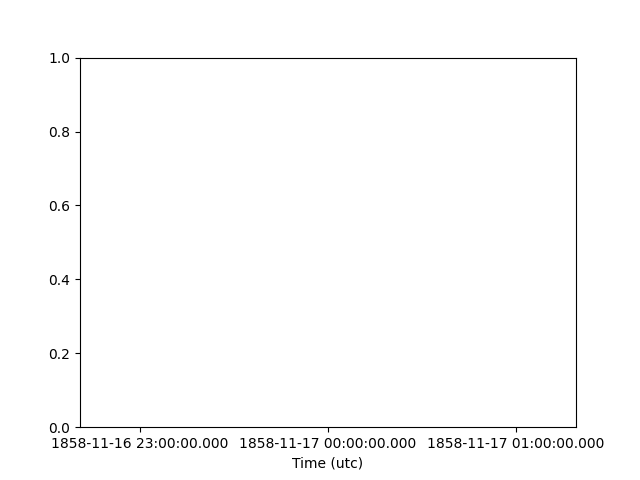

In [35]:
fig, ax = plt.subplots()
ax.plot(results["frame_times"], results["aperture_positions"][0], label='X')
ax.plot(results["frame_times"], results["aperture_positions"][1], label='Y')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.set_ylabel("Mean Aperture Position")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

In [75]:
np.argmax(results["aperture_positions"][0])

1016

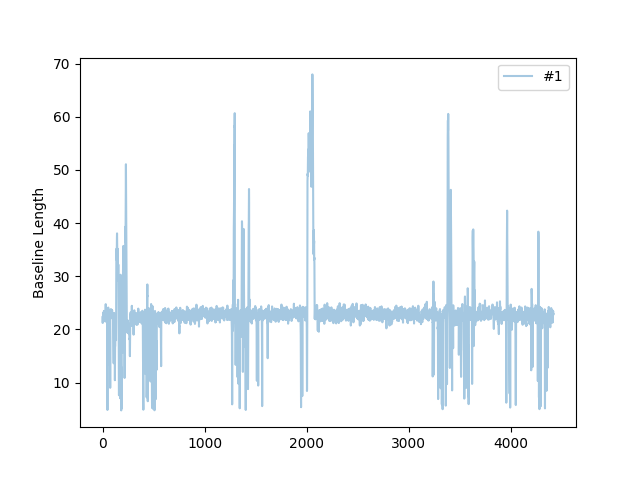

In [36]:
fig, ax = plt.subplots()
ax.plot(results["baseline_lengths"][0], label='#1', alpha=0.4)
ax.set_ylabel("Baseline Length")
plt.legend()
plt.show()

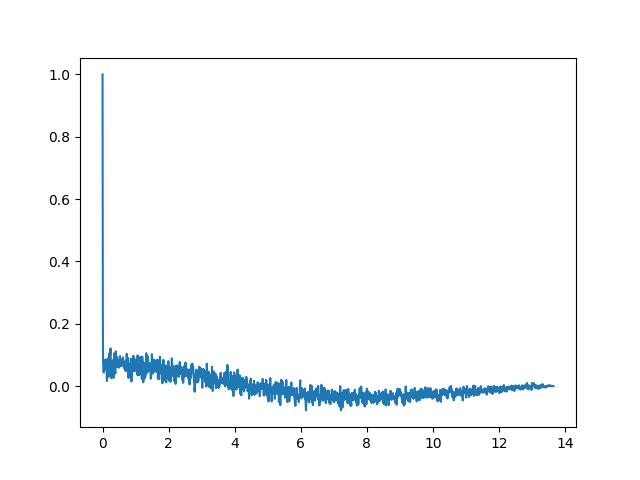

In [152]:
b0 = results["baseline_lengths"][0] - results["baseline_lengths"][0].mean()
dt = (results["frame_times"][1] - results["frame_times"][0]).to_value('sec')
autocor = np.correlate(b0, b0, mode='full')
autocor = autocor[autocor.size // 2 :]
fig = plt.figure()
plt.plot(dt * np.arange(autocor.size), autocor/autocor.max())
plt.show()